In [1]:
# https://www.kaggle.com/code/tiiktak/fashion-mnist-with-alexnet-in-pytorch-92-accuracy/notebook

In [2]:
# nn.Linear(28*28, 512) = w < R^(784x512)

import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader


In [3]:
# training batches of our network
epochs = 10
# size of each batch
batch_size = 512

device = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)
print(device)

1.10.0+cu111
cuda


In [4]:
# prepare datasets
from torchvision.transforms import ToTensor

transform = transforms.Compose([transforms.Resize(227), ToTensor()]) # 227x227 : input image but fashionMNIST's input image : 28x28
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


In [5]:
from torch.utils.data import DataLoader

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

Sandal


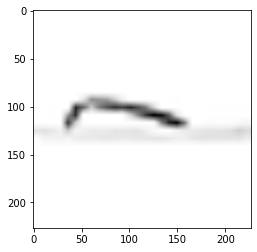

In [6]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")
    
# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [7]:
class fashion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential( # x < R^(227x227x1)  | w1 < R^(11x11x1x96) == 55(which means (227-11)/4)x55x96
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) # (55-3+1)/2 = 26.5 = 27
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out) # 64x4096x1x1
        out = out.view(out.size(0), -1) # 64x4096
        
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        
        return out
        

In [8]:
model = fashion_mnist_alexnet().to(device)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())

In [9]:
from torchsummary import summary as summary_

summary_(model, (1,227,227), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 96, 55, 55]          11,712
              ReLU-2          [512, 96, 55, 55]               0
         MaxPool2d-3          [512, 96, 27, 27]               0
            Conv2d-4         [512, 256, 27, 27]         614,656
              ReLU-5         [512, 256, 27, 27]               0
         MaxPool2d-6         [512, 256, 13, 13]               0
            Conv2d-7         [512, 384, 13, 13]         885,120
              ReLU-8         [512, 384, 13, 13]               0
            Conv2d-9         [512, 384, 13, 13]       1,327,488
             ReLU-10         [512, 384, 13, 13]               0
           Conv2d-11         [512, 256, 13, 13]         884,992
             ReLU-12         [512, 256, 13, 13]               0
        MaxPool2d-13           [512, 256, 6, 6]               0
           Linear-14                [51

In [10]:
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         target = target.type(torch.LongTensor)
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target) # criterion = MEA or MSE
#         loss.backward()
#         optimizer.step()
#         if (batch_idx + 1) % 50 == 0:
#             print("Train Epoch:{} [{}/{} ({:/0f}%)]\tLoss: {:.6f}".format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()
#             ))

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += criterion(output, target, reduction='sum').item()
#             pred = output.max(1, keepdim=True)[1]
#             correct += pred.eq(target.view_as(pred)).sum().item()
        
#         test_loss /= len(test_loader.dataset)
#         print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
#             test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)
#         ))
#         print('='*50)

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [ ]:
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)

Train Epoch:1 [1856/60000 (3%)]	Loss: 1.083595
Train Epoch:1 [3776/60000 (6%)]	Loss: 0.883576
Train Epoch:1 [5696/60000 (9%)]	Loss: 0.882255
Train Epoch:1 [7616/60000 (13%)]	Loss: 0.647190
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.540642
Train Epoch:1 [11456/60000 (19%)]	Loss: 0.678961
Train Epoch:1 [13376/60000 (22%)]	Loss: 0.735797
Train Epoch:1 [15296/60000 (25%)]	Loss: 0.665839
Train Epoch:1 [17216/60000 (29%)]	Loss: 0.475991
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.489610
Train Epoch:1 [21056/60000 (35%)]	Loss: 0.649605
Train Epoch:1 [22976/60000 (38%)]	Loss: 0.480917
Train Epoch:1 [24896/60000 (41%)]	Loss: 0.381356
Train Epoch:1 [26816/60000 (45%)]	Loss: 0.685879
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.345098
Train Epoch:1 [30656/60000 (51%)]	Loss: 0.412779
Train Epoch:1 [32576/60000 (54%)]	Loss: 0.270462
Train Epoch:1 [34496/60000 (57%)]	Loss: 0.579772
Train Epoch:1 [36416/60000 (61%)]	Loss: 0.564830
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.318793
Train Epoch:1 [40256/60000 (